# **Exercise Sheet 5: Classification**

# Part A: Foundations & Concepts

Before you start coding and building classification models, take some time to consider the key concepts and motivations behind classification techniques.

Reflect on these ideas independently before turning to ChatGPT or other resources for help. Discussing your thoughts with classmates is also highly encouraged!

## 1. General Concepts

### a) What type of outcome do you have in a classification task and how is this different from regression task?

#### Your Answer:

#### Solution:
- Classification: Outcome is categorical (e.g., disease vs no disease)
- Regression: Outcome is continuous (e.g., predicting insulin levels)

### b) What is the difference between an explanatory and prediction(classification) logistic regression model?

#### Your Answer:

#### Solution:
- Explanatory: 
    - Focuses on understanding the relationship between predictors and outcome, to explain the outcome.
    - Focus on interpretability
    - Use all data to fit a model and interpret coefficients and p-values.
- Prediction:
    - Focuses on predicting the outcome, not necessarily understanding the relationship. 
    - Try to build a model that generalizes well to new data. 
    - Use accuracy, confusion matrix, cross-validation to evalute the performance

### c) Which metrics are used to evaluate a classification model?
Briefly explain each metric.

#### Your Answer:

#### Solution:
- Accuracy: The proportion of correct predictions out of all predictions made.
- ROC curve: A graphical representation of the true positive rate (sensitivity) against the false positive rate (1-specificity) at various threshold settings.
- Confusion matrix: Summarizes performance by showing the counts of true positives, true negatives, false positives, and false negatives.
- Note there are more like precision, recall, F1-score, etc. Great job if you mentioned those!

### d) How do you get a prediction from the output of a Logistic regression?
- Logistic regression predicts the probability of having outcome = category 1. This is a continuous value between 0 and 1. 
- How do you convert this into a predicted category?

#### Your Answer:

#### Solution:
- Usually we choose a threshold (e.g., 0.5) to classify the outcome.
- So if the predicted probability is greater than 0.5, we classify it as category 1, otherwise as category 0.

### e) How does KNN classification work? Briefly describe the mechanism.

#### Your Answer:

#### Solution:
KNN works as follows for a data point:
1. Find the k nearest neighbors based on a distance metric (e.g., Euclidean distance)
2. Find the most common class among these neighbors
3. Assign the class to the data point based on the majority vote

*Important:* KNN does not learn a model of the data but rather remembers the data and uses it for classification.

### f) How does SVM classification work? Briefly describe the mechanism.

#### Your Answer:

#### Solution:
SVM tries to find a seperation line between classes that maximizes the *margin* between the classes. You can control the number of 'acceptable misclassifications' by adjusting the C parameter. 

### g) How do you choose the parameters of the models?
- In KNN, we have to choose a vlue of the parameter k. 
- In SVM, we have to choose a value of the parameter C and what kernel to use.
- Are there general strategies?

#### Your Answer:

#### Solution:
There is no straight-forward way to choose the parameters of the models, as they heavily depend on the data and the problem at hand. However, common strategies include:
- Cross-validation: Gives a robust estimation of the model's performance for a given set of parameters.
- Grid search: Explore all (or a subset of) combinations of parameters to find the best one.

In practice this could look like:
- For KNN, you might try different values of k (e.g., 1 to 5), perform cross-validation for each k, and select the one with the best performance.
- For SVM, you might do a grid search with all combinations of C values (0.1, 0.5, 1) and kernel types (e.g., linear and radial) and evaluate their performance using cross-validation. In this example we would test 6 different models (2 kernels * 3 C values = 6 models) and choose the one with the best performance.

# Part B: Coding & Visualization

Now let's put our understanding of classification algorithms into practice! We'll begin by importing the necessary libraries.

Hint: You may find the provided helper functions useful for some tasks, but you are welcome to write your own code as well.

## Notes:
- task 2 currently supports One-Hot encoding or Gower. I'd suggest to choose one
- Dataset in task 2 is simulated and unbalanced and does not give super satisfying answers
- Visualizing the decision boundary of SVM in high-dimensions is not possible, so we just visualize the data and color them based on prediction
- TODO: There's an issue somewhere here because the ridge regression coefficents are the same for all features
- I used the sahd dataset, which works good imo, the thiomon is probably to big for this task


In [1]:
# Standard Libraries
import pandas as pd
import numpy as np
import warnings

# Scikit-learn: Data Processing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Scikit-learn: Models and Metrics
from sklearn.linear_model import LogisticRegression, RidgeClassifierCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# Visualization
import matplotlib.pyplot as plt

# UMAP for dimensionality reduction
from umap import UMAP

# Helper Functions
from helper import (
    simple_feature_importance,
    coef_feature_importance,
    evaluate_confusion_matrix,
    evaluate_roc,
    plot_projection
)

import gower

warnings.filterwarnings("ignore")

## 2. KNN

### a) Load the dataset `todo.csv` and explore it.
- What outcome do you want to predict?
- What predictors do you want to use?

In [2]:
# Student Code

In [3]:
# Simulate Dataset about Autoimmune Hepatitis
np.random.seed(42)
n = 200

# Continuous variables
age = np.random.normal(45, 12, n).astype(int)
alt = np.random.normal(60, 25, n)  # Alanine transaminase (liver enzyme)
ast = np.random.normal(70, 30, n)  # Aspartate transaminase (liver enzyme)
igg = np.random.normal(14, 4, n)   # Immunoglobulin G (g/L)

# Categorical variables
sex = np.random.choice(['male', 'female'], n)
alcohol = np.random.choice(['none', 'moderate', 'heavy'], n)
family_autoimmune = np.random.choice(['yes', 'no'], n)
ethnicity = np.random.choice(['white', 'black', 'asian', 'other'], n)

# Binary outcome: autoimmune hepatitis (rare, ~15% prevalence, risk increases with some features)
risk = (
    (igg > 16).astype(int) +
    (alt > 80).astype(int) +
    (family_autoimmune == 'yes').astype(int) +
    (sex == 'female').astype(int)
)
prob = 1 / (1 + np.exp(-(-2.5 + 0.9*risk)))
autoimmune_hepatitis = np.random.binomial(1, prob)

df = pd.DataFrame({
    'age': age,
    'ALT': alt,
    'AST': ast,
    'IgG': igg,
    'sex': sex,
    'alcohol': alcohol,
    'family_autoimmune': family_autoimmune,
    'ethnicity': ethnicity,
    'autoimmune_hepatitis': autoimmune_hepatitis
})

print(df.head())
print(df.dtypes)
print(df['autoimmune_hepatitis'].value_counts())
print(df['alcohol'].value_counts())
print(df['family_autoimmune'].value_counts())

   age        ALT        AST        IgG     sex   alcohol family_autoimmune  \
0   50  68.944684  22.167170  17.027954  female     heavy                no   
1   43  74.019613  52.018749  10.311339    male  moderate                no   
2   52  87.076281  70.157311  17.478424  female     heavy                no   
3   63  86.345051  71.409418  19.422551    male      none               yes   
4   42  25.558266  56.498036  15.653740    male  moderate               yes   

  ethnicity  autoimmune_hepatitis  
0     other                     1  
1     other                     0  
2     other                     0  
3     black                     0  
4     asian                     0  
age                       int64
ALT                     float64
AST                     float64
IgG                     float64
sex                      object
alcohol                  object
family_autoimmune        object
ethnicity                object
autoimmune_hepatitis      int32
dtype: object
autoimm

In [4]:
# Solution
# df = pd.read_csv("todo.csv")

In [5]:
print(df.shape)
df.head()

(200, 9)


,age,ALT,AST,IgG,sex,alcohol,family_autoimmune,ethnicity,autoimmune_hepatitis
0,50,68.944684,22.167170,17.027954,female,heavy,no,other,1
1,43,74.019613,52.018749,10.311339,male,moderate,no,other,0
2,52,87.076281,70.157311,17.478424,female,heavy,no,other,0
3,63,86.345051,71.409418,19.422551,male,none,yes,black,0
4,42,25.558266,56.498036,15.653740,male,moderate,yes,asian,0


In [6]:
# Check the features and outcomes
print("Features:")
print(df.columns.tolist())

Features:
['age', 'ALT', 'AST', 'IgG', 'sex', 'alcohol', 'family_autoimmune', 'ethnicity', 'autoimmune_hepatitis']


In [7]:
# Check for categorical features and their values
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   age                   200 non-null    int64  
 1   ALT                   200 non-null    float64
 2   AST                   200 non-null    float64
 3   IgG                   200 non-null    float64
 4   sex                   200 non-null    object 
 5   alcohol               200 non-null    object 
 6   family_autoimmune     200 non-null    object 
 7   ethnicity             200 non-null    object 
 8   autoimmune_hepatitis  200 non-null    int32  
dtypes: float64(3), int32(1), int64(1), object(4)
memory usage: 13.4+ KB
None


In [8]:
# Get unique values for categorical features
for col in df.select_dtypes(include=['object']).columns:
    print(f"Unique values in {col}: {df[col].unique()}")

Unique values in sex: ['female' 'male']
Unique values in alcohol: ['heavy' 'moderate' 'none']
Unique values in family_autoimmune: ['no' 'yes']
Unique values in ethnicity: ['other' 'black' 'asian' 'white']


In [9]:
# Prepare data for modeling
X = df.drop(columns=["autoimmune_hepatitis"])
y = df["autoimmune_hepatitis"]

### b1) To include categorical variables in KNN, perform One-Hot Encoding on the categorical variables. 

In [10]:
# Student Code

In [11]:
# One-hot encode categorical features
X = pd.get_dummies(X)
print(X.head())

   age        ALT        AST        IgG  sex_female  sex_male  alcohol_heavy  \
0   50  68.944684  22.167170  17.027954        True     False           True   
1   43  74.019613  52.018749  10.311339       False      True          False   
2   52  87.076281  70.157311  17.478424        True     False           True   
3   63  86.345051  71.409418  19.422551       False      True          False   
4   42  25.558266  56.498036  15.653740       False      True          False   

   alcohol_moderate  alcohol_none  family_autoimmune_no  \
0             False         False                  True   
1              True         False                  True   
2             False         False                  True   
3             False          True                 False   
4              True         False                 False   

   family_autoimmune_yes  ethnicity_asian  ethnicity_black  ethnicity_other  \
0                  False            False            False             True   
1     

### b2) To include categorical variables in KNN, calculate gowers distance matrix for KNN. 

In [12]:
# Student Code

In [13]:
# Calculate Gowers distance
# gower_distance = gower.gower_matrix(X)

### c) Perform KNN using k=1 to k=7.
- Evaluate the model using cross-validation
- Plot the accuracy of the model for each k value
- What is the best k value?

In [14]:
# Student Code

In [15]:
# Plot accuracy for each k (showing min/max across folds)

best_knn = None
best_model = ""
best_score = 0

k_range = range(1, 8)
cv_scores = []
cv_min = []
cv_max = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X, y, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())
    cv_min.append(scores.min())
    cv_max.append(scores.max())

    if scores.mean() > best_score:
        best_model = 'OneHot k=' + str(k)
        best_score = scores.mean()
        best_knn = knn

# Create and print table
results_df = pd.DataFrame({
    'mean_accuracy': cv_scores,
    'min_accuracy': cv_min,
    'max_accuracy': cv_max,
}, index=list(k_range))
results_df.index.name = 'k'
print(results_df)


   mean_accuracy  min_accuracy  max_accuracy
k                                           
1          0.665         0.550         0.750
2          0.760         0.700         0.800
3          0.715         0.625         0.775
4          0.755         0.675         0.800
5          0.750         0.675         0.800
6          0.770         0.700         0.800
7          0.755         0.700         0.800


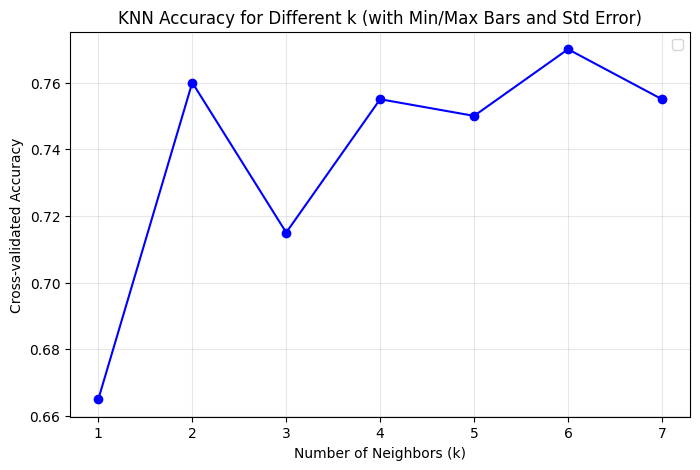

In [16]:

# TODO: Do we want to provide a plot function or leave the plot question?

# Plot with error bars (std) and min/max as bars
plt.figure(figsize=(8,5))
plt.plot(k_range, cv_scores, marker='o', color='blue')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Cross-validated Accuracy')
plt.title('KNN Accuracy for Different k (with Min/Max Bars and Std Error)')
plt.legend()
plt.grid(True, alpha=0.3)

In [17]:
# Alternative option if used gower distance
gower_distance = gower.gower_matrix(X)

k_range = range(1, 8)
cv_scores = []
cv_min = []
cv_max = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k, metric='precomputed')
    scores = cross_val_score(knn, gower_distance, y, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())
    cv_min.append(scores.min())
    cv_max.append(scores.max())

    if scores.mean() > best_score:
        best_model = 'Gower k=' + str(k)
        best_score = scores.mean()
        best_knn = knn

# Create and print table
results_df = pd.DataFrame({
    'mean_accuracy': cv_scores,
    'min_accuracy': cv_min,
    'max_accuracy': cv_max,
}, index=list(k_range))
results_df.index.name = 'k'
print(results_df)

   mean_accuracy  min_accuracy  max_accuracy
k                                           
1          0.620         0.550         0.675
2          0.780         0.750         0.800
3          0.735         0.700         0.775
4          0.790         0.750         0.825
5          0.765         0.700         0.825
6          0.770         0.750         0.800
7          0.765         0.725         0.775


### d) Plot the confusion matrix and interpret the results.

In [18]:
# Student Code

CONFUSION MATRIX
Actual vs Predicted:
True Negatives (TN):  150
False Positives (FP): 4
False Negatives (FN): 38
True Positives (TP):  8

Overall Error Rate: 21.0%
Type I Error (False Positive Rate): 2.6%
Type II Error (False Negative Rate): 82.6%


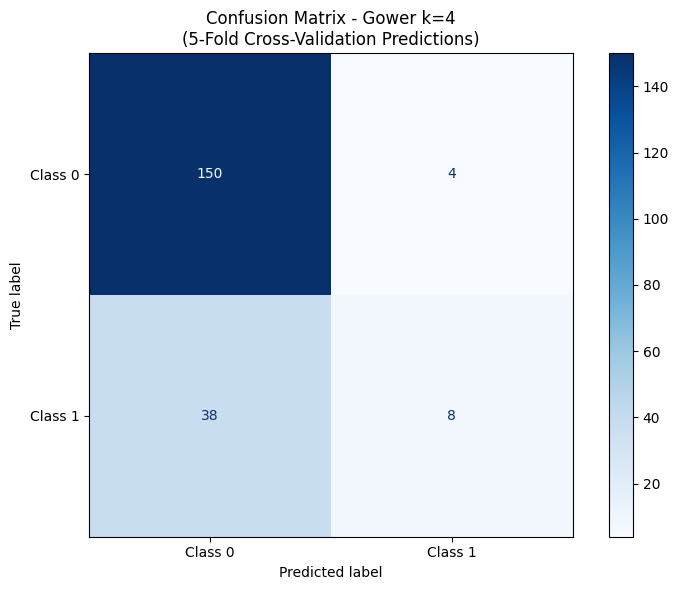

In [19]:
# Plot Confusion Matrix
if best_knn is None:
    print("No best model found.")
elif best_model.find("OneHot") != -1:
    evaluate_confusion_matrix(X, y, best_knn, model_name=best_model)
elif best_model.find("Gower") != -1:
    evaluate_confusion_matrix(gower_distance, y, best_knn, model_name=best_model)

ROC-AUC PERFORMANCE
Gower k=4:
  Cross-validation AUC: 0.486 (±0.091)
  ROC AUC: 0.487



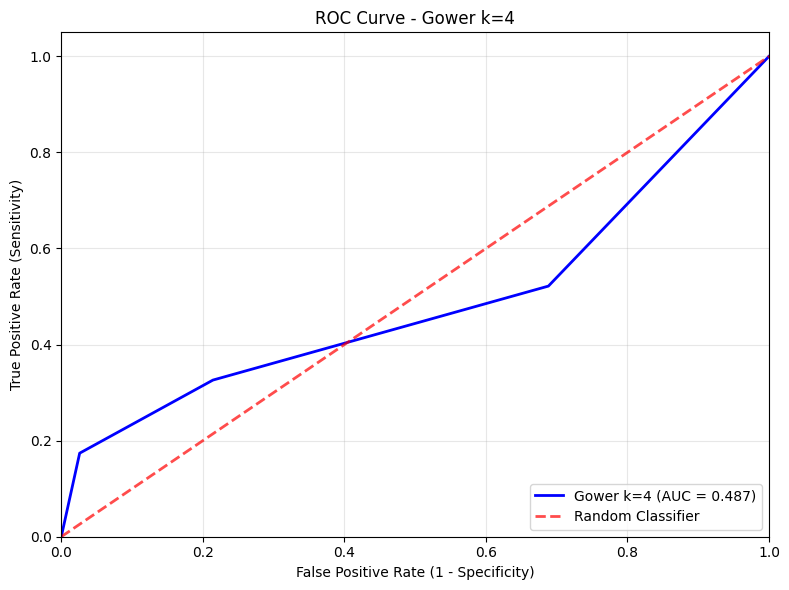

In [20]:
if best_knn is None:
    print("No best model found.")
elif best_model.find("OneHot") != -1:
    evaluate_roc(X, y, best_knn, model_name=best_model)
elif best_model.find("Gower") != -1:
    evaluate_roc(gower_distance, y, best_knn, model_name=best_model)

### e) Plot the data using PCA or UMAP and color the points by the predicted class.
- What do you observe about the class distribution in the PCA/UMAP space?

In [ ]:
# TODO:

## 3. SVM

https://htmlpreview.github.io/?https://github.com/higgi13425/medicaldata/blob/master/man/description_docs/thiomon_desc.html

Maybe dataset is too big, it takes a long time to run

### a) Load the dataset `sahd.csv` and explore it.
- What outcome do you want to predict?
- What predictors do you want to use?
- Do you have categorical variables?
- Do you have missing values?

In [21]:
# Student Code

In [22]:
# Solution
df = pd.read_csv('sahd.csv')

In [23]:
print(df.shape)
df.head()

(462, 8)


,chd,sbp,tobacco,ldl,famhist,obesity,alcohol,age
0,1,160,12.00,5.73,Present,25.30,97.20,52
1,1,144,0.01,4.41,Absent,28.87,2.06,63
2,0,118,0.08,3.48,Present,29.14,3.81,46
3,1,170,7.50,6.41,Present,31.99,24.26,58
4,1,134,13.60,3.50,Present,25.99,57.34,49


In [24]:
# Remove missing values
df = df.dropna()

In [25]:
# Check the features and outcomes
print("Features:")
print(df.columns.tolist())

Features:
['chd', 'sbp', 'tobacco', 'ldl', 'famhist', 'obesity', 'alcohol', 'age']


In [26]:
# Check for categorical features and their values
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 462 entries, 0 to 461
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   chd      462 non-null    int64  
 1   sbp      462 non-null    int64  
 2   tobacco  462 non-null    float64
 3   ldl      462 non-null    float64
 4   famhist  462 non-null    object 
 5   obesity  462 non-null    float64
 6   alcohol  462 non-null    float64
 7   age      462 non-null    int64  
dtypes: float64(4), int64(3), object(1)
memory usage: 29.0+ KB
None


In [27]:
# Prepare data for modeling
X = df.drop(columns=["chd"])
y = df["chd"]

# One-hot encode categorical features
X = pd.get_dummies(X, drop_first=True)

### b) Perform SVM with C=1 and a linear kernel.
- Evaluate the model using cross-validation
- What accuracies do you get?

In [28]:
# Student Code

In [29]:
# Perform SVM with C=1, linear kernel and cross validation
svm_model_initial = SVC(C=1, kernel='linear', random_state=42, probability=True)
scores = cross_val_score(svm_model_initial, X, y, cv=5, scoring='accuracy')
print(f"SVM Scores: {scores}")
print(f"SVM Accuracy: {scores.mean():.4f} ± {scores.std():.4f}")

SVM Scores: [0.72043011 0.7311828  0.66304348 0.72826087 0.76086957]
SVM Accuracy: 0.7208 ± 0.0320


### c) Perform a grid search for C = [0.1, 0.5, 1] and kernel = [linear, radial].
- Use cross-validation
- What is the best combination of parameters?

In [30]:
# Student Code

In [31]:
# Grid search for SVM with different C and kernel

C = [0.1, 0.5, 1]
kernel = ['linear', 'rbf']


In [32]:

# Option A use sklearn's GridSearchCV
from sklearn.model_selection import GridSearchCV
param_grid = {
    'C': C,
    'kernel': kernel
}   
#grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy')
#grid_search.fit(X, y)


In [33]:

# Option B use manual grid search
best_svm = None
best_model = ""
best_score = 0
results = []

for c in C:
    for k in kernel:
        svm_model = SVC(C=c, kernel=k, random_state=42, probability=True)
        scores = cross_val_score(svm_model, X, y, cv=5, scoring='accuracy')
        results.append({
            'C': c,
            'kernel': k,
            'mean_accuracy': scores.mean(),
            'std_accuracy': scores.std()
        })
        
        if scores.mean() > best_score:
            best_model = f'SVM C={c} kernel={k}'
            best_score = scores.mean()
            best_svm = svm_model

best_svm.fit(X, y)

results_df = pd.DataFrame(results)
results_df.index.name = 'index'

# Group by kernel for better visibility
grouped = results_df.groupby('kernel')
for kernel_name, group in grouped:
    print(f"\nResults for kernel = '{kernel_name}':")
    print(group[['C', 'mean_accuracy', 'std_accuracy']].to_string(index=False))


print(f"\nBest model: {best_model} with accuracy {best_score:.4f}")


Results for kernel = 'linear':
  C  mean_accuracy  std_accuracy
0.1       0.727232      0.044448
0.5       0.720781      0.033193
1.0       0.720757      0.031953

Results for kernel = 'rbf':
  C  mean_accuracy  std_accuracy
0.1       0.653670      0.001832
0.5       0.651496      0.005363
1.0       0.649322      0.006687

Best model: SVM C=0.1 kernel=linear with accuracy 0.7272


### d) Plot the data using PCA or UMAP and color based on the predicted class.
- What do you observe?

In [34]:
# Student Code

In [35]:
# Reduce Data

pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)

# Reduce data with umap
umap = UMAP(n_components=2, random_state=42)
X_reduced = umap.fit_transform(X)


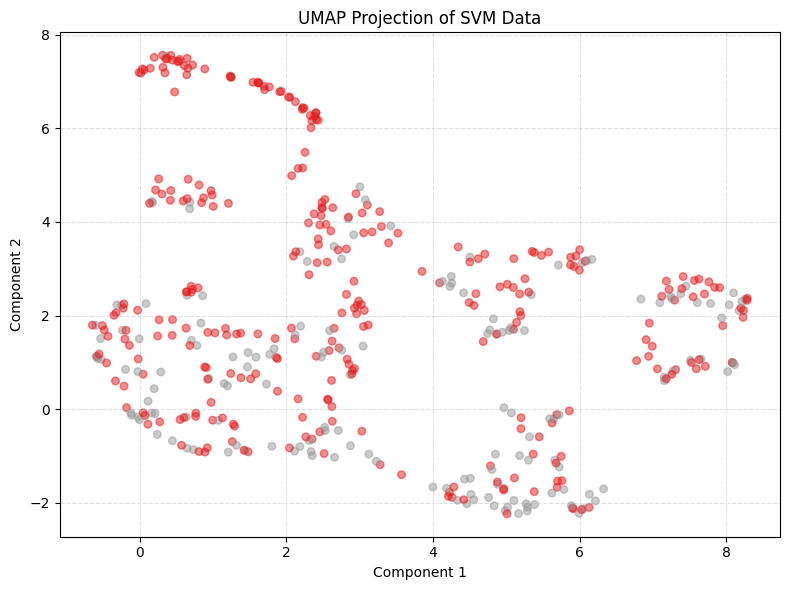

In [36]:

# Plot PCA results
plot_projection(X_reduced, y, title='UMAP Projection of SVM Data', 
                xlabel='Component 1', ylabel='Component 2',
                dataset_name='TODO Data')

Does not seem like the visualization works, maybe because dataset is not normalized or too big? Look at explained variance

### e) Plot the the confusion matrix of the initial params and the best params.
- What do you conclude?
- Which one performs better?

In [37]:
# Student Code

CONFUSION MATRIX
Actual vs Predicted:
True Negatives (TN):  253
False Positives (FP): 49
False Negatives (FN): 80
True Positives (TP):  80

Overall Error Rate: 27.9%
Type I Error (False Positive Rate): 16.2%
Type II Error (False Negative Rate): 50.0%
CONFUSION MATRIX
Actual vs Predicted:
True Negatives (TN):  257
False Positives (FP): 45
False Negatives (FN): 81
True Positives (TP):  79

Overall Error Rate: 27.3%
Type I Error (False Positive Rate): 14.9%
Type II Error (False Negative Rate): 50.6%


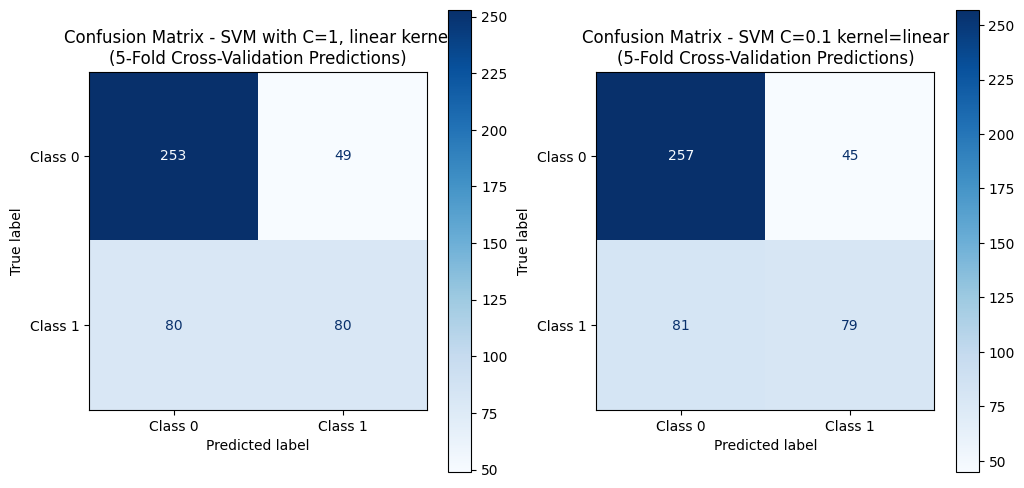

In [38]:
# Plot the two confusion matrices in one plot
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
evaluate_confusion_matrix(X, y, svm_model_initial, model_name="SVM with C=1, linear kernel", ax=ax[0])
evaluate_confusion_matrix(X, y, best_svm, model_name=best_model, ax=ax[1])

Again the dataset seems to be biased towards Class 0 outcomes (no heart disease). Also the difference is not that big between the two models

### f) Plot the ROC curve for both parameter combinations and report AUC.
- Does this plot support your conclusion?

In [39]:
# Student Code

ROC-AUC PERFORMANCE
SVM C=1, kernel=linear:
  Cross-validation AUC: 0.761 (±0.032)
  ROC AUC: 0.758

SVM C=0.1 kernel=linear:
  Cross-validation AUC: 0.763 (±0.036)
  ROC AUC: 0.760



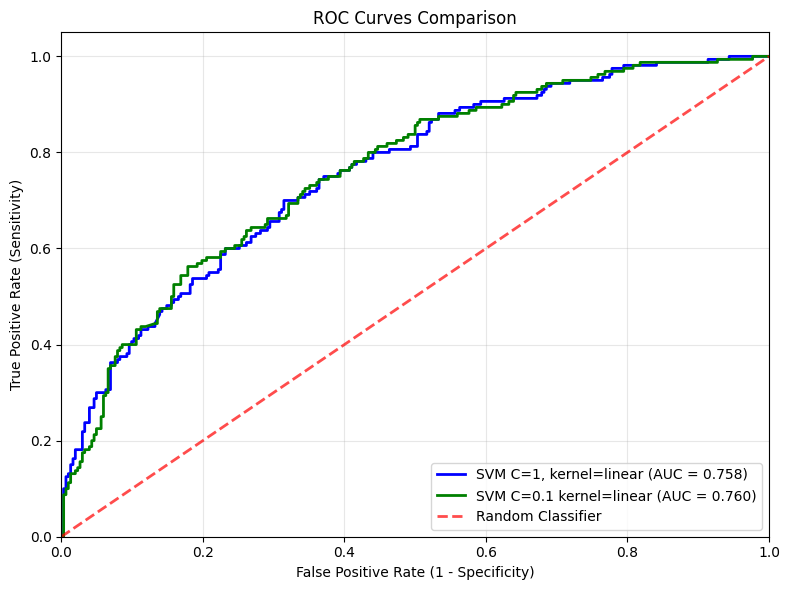

In [40]:
# Solution
evaluate_roc(X, y, models=[svm_model_initial, best_svm], model_names=["SVM C=1, kernel=linear", best_model])

## 4. Classification Overview

### a) Load and explore the dataset `sahd.csv`.
- What variables do you have? 
- Do you have categorical variables?

In [41]:
# Student Code

In [42]:
# Solution
df = pd.read_csv("sahd.csv")

In [43]:
print(df.shape)
df.head()

(462, 8)


,chd,sbp,tobacco,ldl,famhist,obesity,alcohol,age
0,1,160,12.00,5.73,Present,25.30,97.20,52
1,1,144,0.01,4.41,Absent,28.87,2.06,63
2,0,118,0.08,3.48,Present,29.14,3.81,46
3,1,170,7.50,6.41,Present,31.99,24.26,58
4,1,134,13.60,3.50,Present,25.99,57.34,49


In [44]:
# Check the features and outcomes
print("Features:")
print(df.columns.tolist())

Features:
['chd', 'sbp', 'tobacco', 'ldl', 'famhist', 'obesity', 'alcohol', 'age']


In [45]:
# Check for categorical features and their values
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 462 entries, 0 to 461
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   chd      462 non-null    int64  
 1   sbp      462 non-null    int64  
 2   tobacco  462 non-null    float64
 3   ldl      462 non-null    float64
 4   famhist  462 non-null    object 
 5   obesity  462 non-null    float64
 6   alcohol  462 non-null    float64
 7   age      462 non-null    int64  
dtypes: float64(4), int64(3), object(1)
memory usage: 29.0+ KB
None


In [46]:
# Get unique values for categorical features
for col in df.select_dtypes(include=['object']).columns:
    print(f"Unique values in {col}: {df[col].unique()}")

Unique values in famhist: ['Present' 'Absent']


In [47]:
# Prepare data for modeling
X = df.drop(columns=["chd"])
y = df["chd"]

# One-hot encode categorical features
X = pd.get_dummies(X, drop_first=True)

### b) Perform logistic and ridge regression.
- What are the optimal alphas for ridge regression?
- Use cross-validation

NOTE: There's no LassoClassifier as the L+ penalty leads to a non-convex optimization problem.

*Hint:* you can use `RidgeClassifierCV` from sklearn.linear_model

In [48]:
# Student Code

In [49]:
# Perform logistic regression with cross validation
log_reg = LogisticRegression(random_state=42)
lr_scores = cross_val_score(log_reg, X, y, cv=5, scoring='accuracy')
log_reg.fit(X, y);

In [50]:
# Perform Ridge regression with cross validation
alphas = np.logspace(-3, 3, 10)
ridge_model = RidgeClassifierCV(alphas=alphas, cv=5, scoring='accuracy')
ridge_model.fit(X, y)

print("Optimal alpha for Ridge Regression:", ridge_model.alpha_)
# from sklearn.linear_model import RidgeClassifier
# ridge_model = RidgeClassifier(alpha=ridge_model.alpha_, random_state=42)
# ridge_model = ridge_model.fit(X, y)

ridge_scores = cross_val_score(ridge_model, X, y, cv=5, scoring='accuracy')

Optimal alpha for Ridge Regression: 46.41588833612773


In [51]:
# Perform Lasso regression with cross validation
# from sklearn.linear_model import LassoCV
# lasso_model = LassoCV(alphas=alphas, cv=5)
# lasso_scores = cross_val_score(lasso_model, X, y, cv=5, scoring='accuracy')

In [52]:
# Put scores in a dataframe and print
results_df = pd.DataFrame({
    'Logistic Regression': lr_scores,
    'Ridge Regression': ridge_scores,
    #'Lasso Regression': lasso_scores
})
results_df.index.name = 'Fold'
print(results_df)

      Logistic Regression  Ridge Regression
Fold                                       
0                0.720430          0.752688
1                0.720430          0.741935
2                0.652174          0.652174
3                0.739130          0.728261
4                0.760870          0.750000


### c) Compare the 2 models using Accuracy, ROC and confusion matrix.
- Which model performs best?

In [53]:
# Student Code

In [54]:
# Print Accuracies
print(f"Logistic Regression Accuracy: {lr_scores.mean():.4f} ± {lr_scores.std():.4f}")
print(f"Ridge Regression Accuracy: {ridge_scores.mean():.4f} ± {ridge_scores.std():.4f}")

Logistic Regression Accuracy: 0.7186 ± 0.0364
Ridge Regression Accuracy: 0.7250 ± 0.0374


CONFUSION MATRIX
Actual vs Predicted:
True Negatives (TN):  254
False Positives (FP): 48
False Negatives (FN): 82
True Positives (TP):  78

Overall Error Rate: 28.1%
Type I Error (False Positive Rate): 15.9%
Type II Error (False Negative Rate): 51.2%
CONFUSION MATRIX
Actual vs Predicted:
True Negatives (TN):  259
False Positives (FP): 43
False Negatives (FN): 84
True Positives (TP):  76

Overall Error Rate: 27.5%
Type I Error (False Positive Rate): 14.2%
Type II Error (False Negative Rate): 52.5%


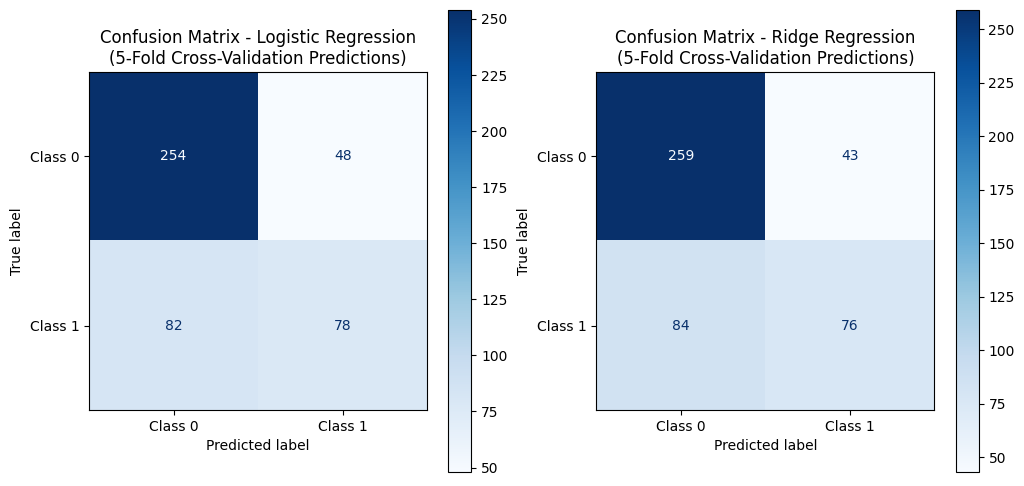

In [55]:
# Plot the two confusion matrices

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
evaluate_confusion_matrix(X, y, log_reg, model_name="Logistic Regression", ax=ax[0])
evaluate_confusion_matrix(X, y, ridge_model, model_name="Ridge Regression", ax=ax[1])

ROC-AUC PERFORMANCE
Logistic Regression:
  Cross-validation AUC: 0.767 (±0.037)
  ROC AUC: 0.766

Ridge Regression:
  Cross-validation AUC: 0.764 (±0.030)
  ROC AUC: 0.761



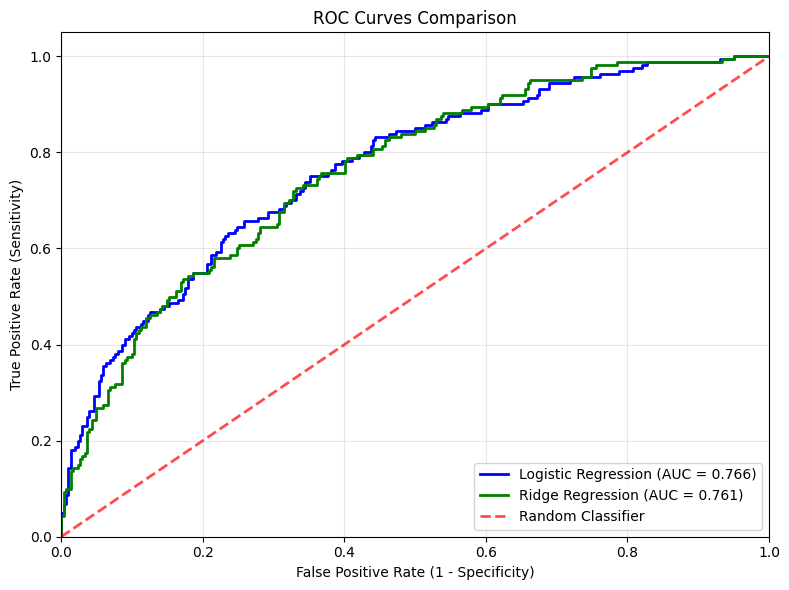

In [56]:
evaluate_roc(X, y, models=[log_reg, ridge_model], model_names=["Logistic Regression", "Ridge Regression"])  

### d) Fit a random forest and report the accuracy, ROC and confusion matrix.
- How does it compare to the other models?

In [57]:
# Student Code

In [58]:
# Fit a random forest
rf_model = RandomForestClassifier(random_state=42)
rf_scores = cross_val_score(rf_model, X, y, cv=5, scoring='accuracy')
rf_model.fit(X, y);

In [59]:
# Report Accuracy
print(f"Random Forest Accuracy: {rf_scores.mean():.4f} ± {rf_scores.std():.4f}")

Random Forest Accuracy: 0.6860 ± 0.0345


CONFUSION MATRIX
Actual vs Predicted:
True Negatives (TN):  250
False Positives (FP): 52
False Negatives (FN): 93
True Positives (TP):  67

Overall Error Rate: 31.4%
Type I Error (False Positive Rate): 17.2%
Type II Error (False Negative Rate): 58.1%


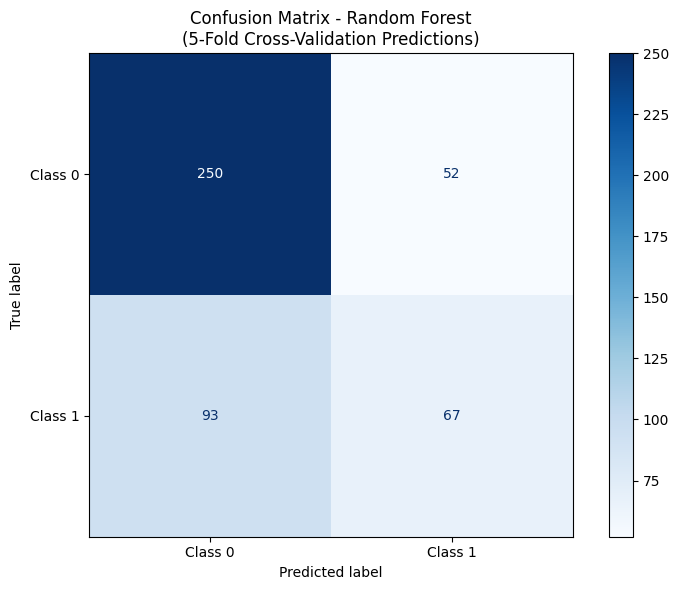

In [60]:
# Confusion Matrix
evaluate_confusion_matrix(X, y, rf_model, model_name="Random Forest")

ROC-AUC PERFORMANCE
Random Forest:
  Cross-validation AUC: 0.721 (±0.025)
  ROC AUC: 0.719



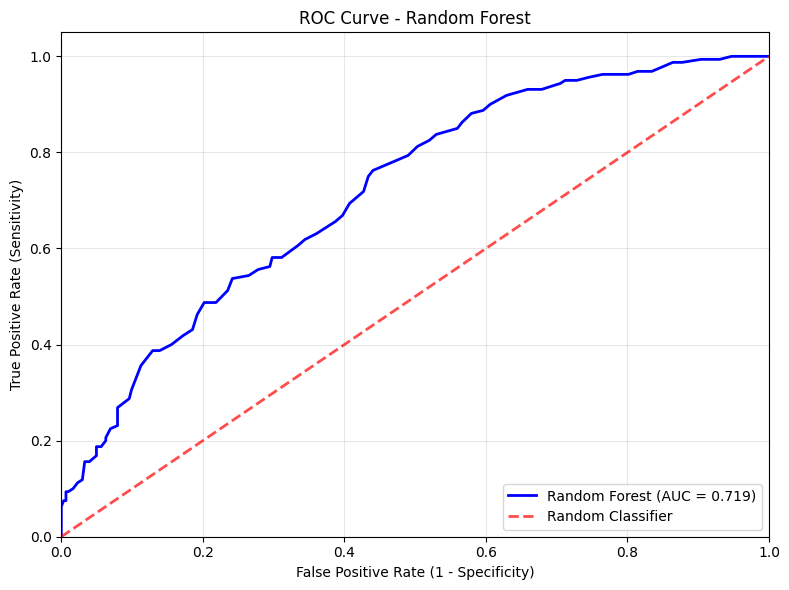

In [61]:
# ROC
evaluate_roc(X, y, rf_model, model_name="Random Forest")

### e) Fit a KNN model and report the accuracy, ROC and confusion matrix.

In [62]:
# Student Code

In [63]:
# Fit a KNN model
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_scores = cross_val_score(knn_model, X, y, cv=5, scoring='accuracy')

In [64]:
# Report Accuracy
print(f"Random Forest Accuracy: {rf_scores.mean():.4f} ± {rf_scores.std():.4f}")

Random Forest Accuracy: 0.6860 ± 0.0345


CONFUSION MATRIX
Actual vs Predicted:
True Negatives (TN):  228
False Positives (FP): 74
False Negatives (FN): 96
True Positives (TP):  64

Overall Error Rate: 36.8%
Type I Error (False Positive Rate): 24.5%
Type II Error (False Negative Rate): 60.0%


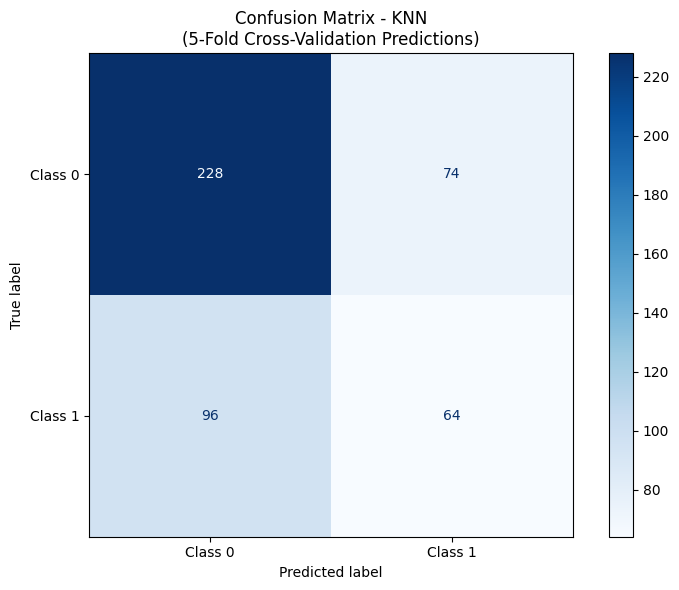

In [65]:
# Report Confusion Matrix
evaluate_confusion_matrix(X, y, knn_model, model_name="KNN")

ROC-AUC PERFORMANCE
KNN:
  Cross-validation AUC: 0.639 (±0.058)
  ROC AUC: 0.641



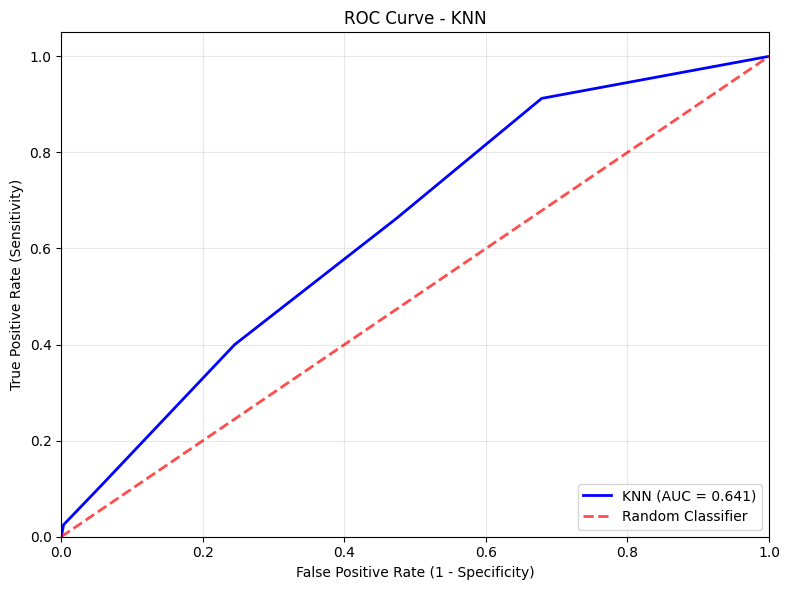

In [66]:
# Report ROC
evaluate_roc(X, y, knn_model, model_name="KNN")

### f) Fit a SVM model and report the accuracy, ROC and confusion matrix.

In [67]:
# Student Code

In [68]:
# Fit SVM
svm_model = SVC(C=1, kernel='linear', random_state=42, probability=True)
svm_scores = cross_val_score(svm_model, X, y, cv=5, scoring='accuracy')
svm_model.fit(X, y);

In [69]:
# Report Accuracy
print(f"SVM Accuracy: {svm_scores.mean():.4f} ± {svm_scores.std():.4f}")

SVM Accuracy: 0.7208 ± 0.0320


CONFUSION MATRIX
Actual vs Predicted:
True Negatives (TN):  253
False Positives (FP): 49
False Negatives (FN): 80
True Positives (TP):  80

Overall Error Rate: 27.9%
Type I Error (False Positive Rate): 16.2%
Type II Error (False Negative Rate): 50.0%


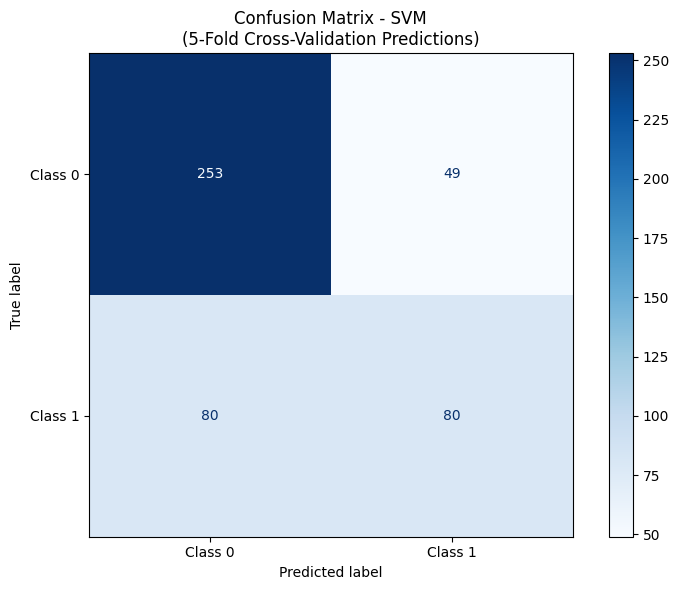

In [70]:
# Report Confusion Matrix
evaluate_confusion_matrix(X, y, svm_model, model_name="SVM")

ROC-AUC PERFORMANCE
SVM:
  Cross-validation AUC: 0.761 (±0.032)
  ROC AUC: 0.758



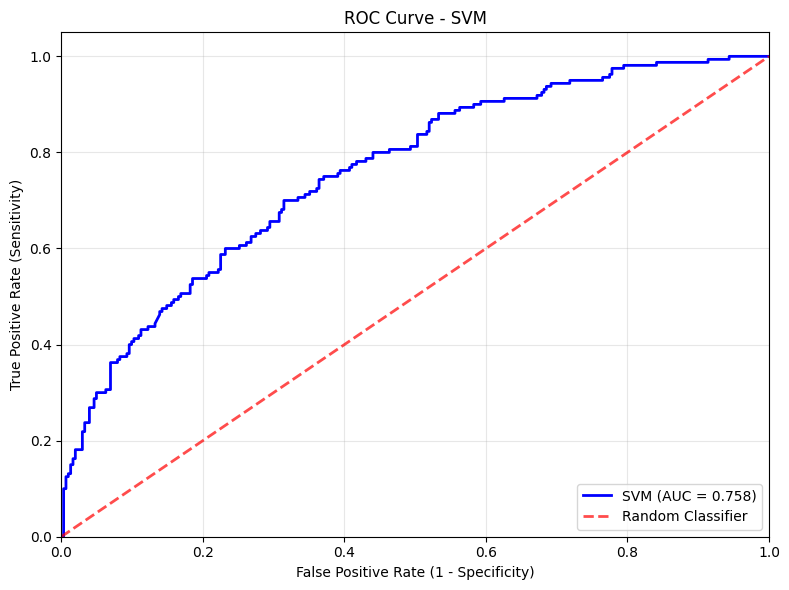

In [71]:
# Report ROC
evaluate_roc(X, y, svm_model, model_name="SVM")

### g) Compare accuracy and ROC of all models.
- Which model performs best?

In [72]:
# Student Code

In [73]:
# Put all mean and std accuracies in a dataframe
results_summary = pd.DataFrame({
    'Model': ['Logistic Regression', 'Ridge Regression', 'Random Forest', 'KNN', 'SVM'],
    'Mean Accuracy': [
        lr_scores.mean(),
        ridge_scores.mean(),
        rf_scores.mean(),
        knn_scores.mean(),
        svm_scores.mean()
    ],
    'Std Accuracy': [
        lr_scores.std(),
        ridge_scores.std(),
        rf_scores.std(),
        knn_scores.std(),
        svm_scores.std()
    ]
})
results_summary.set_index('Model', inplace=True)

print(results_summary)

                     Mean Accuracy  Std Accuracy
Model                                           
Logistic Regression       0.718607      0.036407
Ridge Regression          0.725012      0.037397
Random Forest             0.686045      0.034503
KNN                       0.632071      0.026843
SVM                       0.720757      0.031953


ROC-AUC PERFORMANCE
Logistic Regression:
  Cross-validation AUC: 0.767 (±0.037)
  ROC AUC: 0.766

Ridge Regression:
  Cross-validation AUC: 0.764 (±0.030)
  ROC AUC: 0.761

Random Forest:
  Cross-validation AUC: 0.721 (±0.025)
  ROC AUC: 0.719

KNN:
  Cross-validation AUC: 0.639 (±0.058)
  ROC AUC: 0.641

SVM:
  Cross-validation AUC: 0.761 (±0.032)
  ROC AUC: 0.758



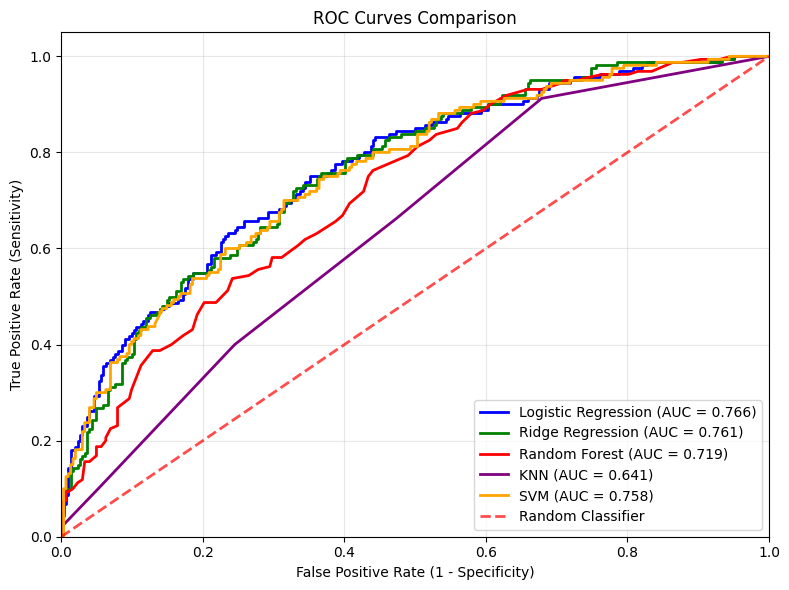

In [74]:
# ROC of all models
models = [log_reg, ridge_model, rf_model, knn_model, svm_model]
model_names = ["Logistic Regression", "Ridge Regression", "Random Forest", "KNN", "SVM"]
evaluate_roc(X, y, models=models, model_names=model_names)

### h) Extract coefficients of logistic and ridge 
- Which features are most important?

In [75]:
# Student Code

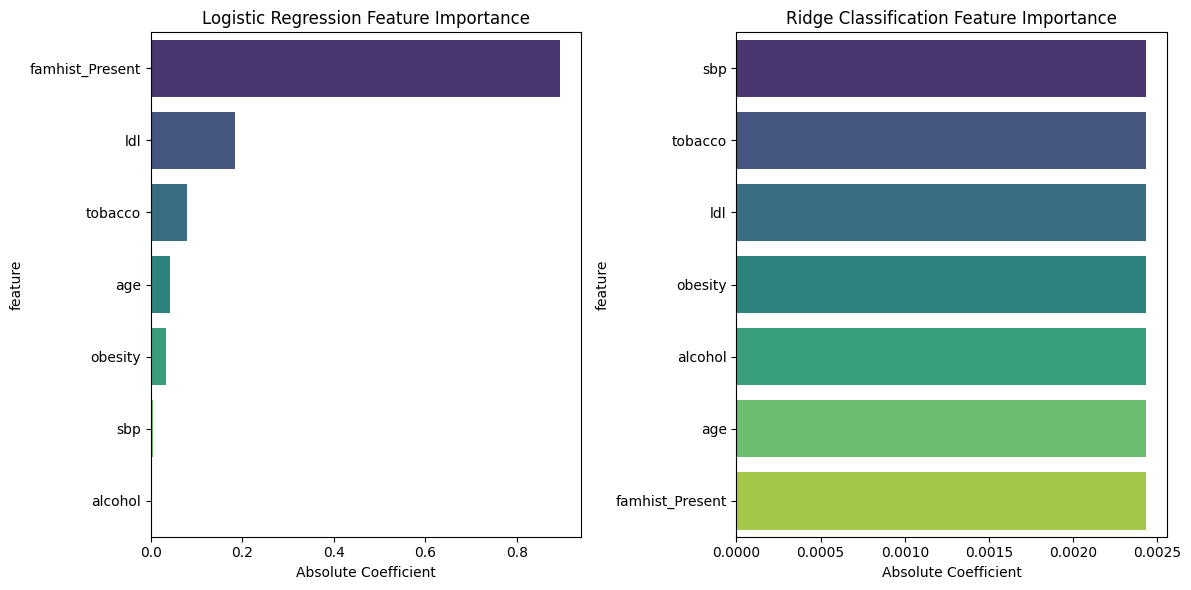

In [76]:
# Plot coefficients for logistic regression and ridge classification
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
# maybe add this function to the handson
coef_feature_importance(X, log_reg, title='Logistic Regression Feature Importance', ax=ax[0])
coef_feature_importance(X, ridge_model, title='Ridge Classification Feature Importance', ax=ax[1])

### i) Extract feature importance from the random forest model.
- Which features are most important?

In [77]:
# Student Code

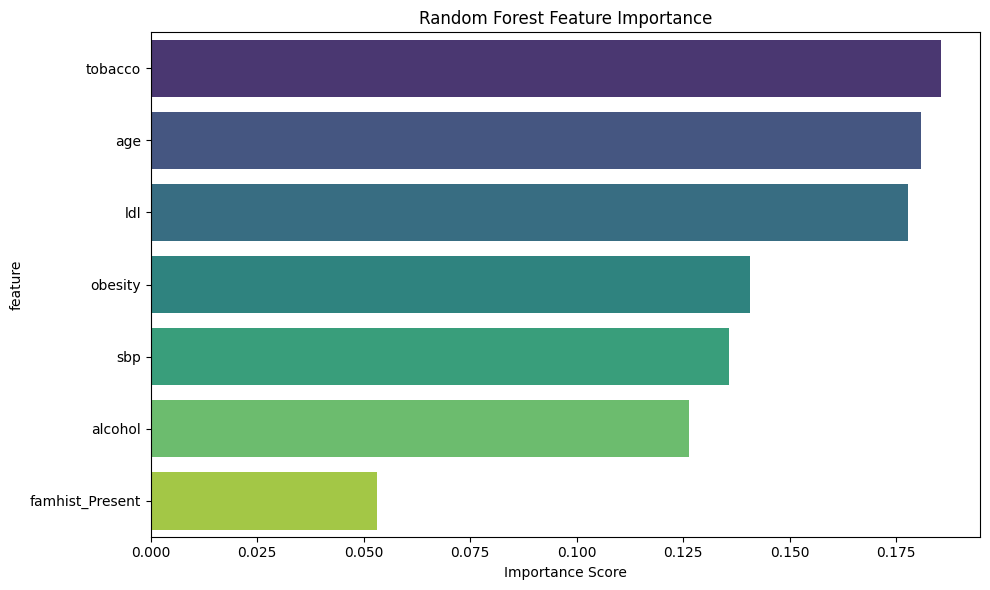

In [78]:
# Plot feature importance for random forest
simple_feature_importance(X, rf_model, title='Random Forest Feature Importance')

### j) Extract feature importance from the SVM model.
- Note: Currently missing from handson

In [79]:
# Student Code

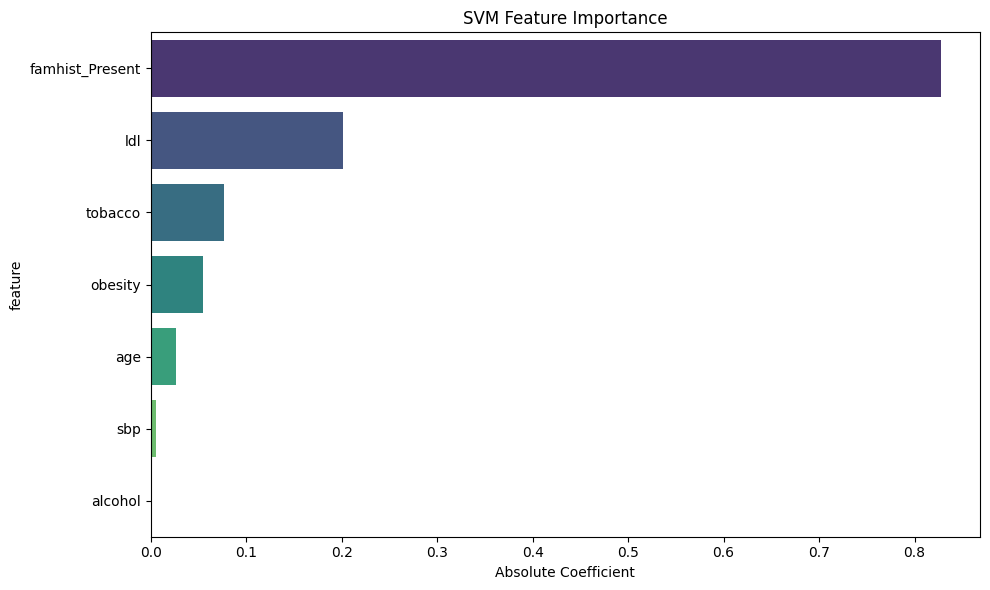

In [80]:
# SVM Feature Importance
coef_feature_importance(X, svm_model, title='SVM Feature Importance')

### k) Compare the feature importance of all models.
- Are the most important features consistent across models?

#### Your Answer:

#### Solution:
Once Dataset fixed

### l) Reflect on interpretability of the models.
- Which models provide interpretability? Which don't?

#### Your Answer:

#### Solution:
Models ordered from most to least interpretable:
- Logistic Regression: Coefficients can be interpreted directly.
- Ridge Regression: Similar to logistic regression, but coefficients are regularized.
- Random Forest: Feature importance can be extracted, but the model is complex.
- SVM: Coefficients are not directly interpretable, but feature importance can be derived from the model.
- KNN: No model, just remembers the data.